In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import optim
from itertools import islice
from Bio import pairwise2
from torch.utils.data import DataLoader,Dataset
import time
import csv
import torch
from torch.autograd import Variable
from Bio import SeqIO
import random
from deap import base, creator, tools, algorithms
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq


/Users/davidedisarno/anaconda3/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
CUDA_FLAG = torch.cuda.is_available()
print(CUDA_FLAG)

False


In [4]:
SEED = 1
torch.manual_seed(SEED)
if CUDA_FLAG:
    torch.cuda.manual_seed(SEED)

SEQ_LEN =465#provare 100
EMBEDDING_LEN = 120#50
NUM_TRAINING_PAIRS = 50 * 500
NUM_EPOCH = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 100

class Config():
    train_data_fp = './demo/pair_shuffle.fa'
    train_target_fp = './demo/dist_shuffle.txt'
    train_num_example = NUM_TRAINING_PAIRS
    train_batch_size = BATCH_SIZE
    num_epoch = NUM_EPOCH
    learning_rate =LEARNING_RATE

In [5]:
class MaxMinout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, embedding1, embedding2):
        shape = list(embedding1.size())
        flat1 = embedding1.view(1, -1)
        flat2 = embedding2.view(1, -1)
        combined = torch.cat((flat1, flat2), 0)
        maxout = combined.max(0)[0].view(*shape)
        # minout = combined.min(0)[0].view(*shape)
        minout = ((combined * -1).max(0)[0].view(*shape) * -1) # workaround for memory leak bug

        return maxout, minout

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxminout = MaxMinout()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
                
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
               
            nn.Conv1d(32, 48, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
        max_pooling_len = SEQ_LEN 
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        self.fc = nn.Sequential(
            nn.Linear(int(48 * max_pooling_len), EMBEDDING_LEN),
        )

    def forward_one_side(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        embedding1 = self.forward_one_side(input1)
        embedding2 = self.forward_one_side(input2)
        maxout, minout = self.maxminout(embedding1, embedding2)
        return maxout, minout
  


    def align_sequences(self, seq1_embedding, seq2_embedding):
        maxout, minout = self.maxminout(seq1_embedding, seq2_embedding)
        return maxout, minout

    def get_embedding(self, sequence):
        seq_tensor = torch.zeros((1, 4, SEQ_LEN))

        for i, c in enumerate(sequence):
            seq_tensor[0, atcg_map.get(c, 0), i] = 1.0

        if CUDA_FLAG:
            seq_tensor = seq_tensor.cuda()

        seq_tensor = Variable(seq_tensor)
        embedding = self.forward_one_side(seq_tensor)

        return embedding


In [6]:
def weight_func(dist):
    return 1.0

class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, maxout, minout, align_dist):
        weight = Variable(torch.FloatTensor([weight_func(x) for x in align_dist.data]), requires_grad=False)
        if CUDA_FLAG:
            weight = weight.cuda()
        loss_contrastive = torch.mean(torch.mul(weight, torch.pow(1 - minout.sum(1)/maxout.sum(1) - align_dist, 2)))

        return loss_contrastive

In [7]:
atcg_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

class SiameseNetworkDataset(Dataset):
    def __init__(self, data_fp, target_fp, N):
        self.data_fp = data_fp
        self.target_fp = target_fp
        self.N = N
        self.data_tensor = self.gen_data_tensor()
        self.target_tensor = self.gen_target_tensor()
        
    def __getitem__(self, index):
        return self.data_tensor[0][index], self.data_tensor[1][index], self.target_tensor[index]

    def __len__(self):
        return self.N
    
    def gen_data_tensor (self):
        seq1 = torch.zeros((self.N, 4, SEQ_LEN))
        seq2 = torch.zeros((self.N, 4, SEQ_LEN))
        cnt = 0
        with open(self.data_fp) as f:
            while True:
                next_n = list(islice(f, 4))
                if not next_n:
                    break
                if cnt >= self.N:
                    break
                read1 = next_n[1].strip()
                read2 = next_n[3].strip()
                for i, c in enumerate(read1):
                    seq1[cnt, atcg_map.get(c, 0), i] = 1.0
                for i, c in enumerate(read2):
                    seq2[cnt, atcg_map.get(c, 0), i] = 1.0
                cnt += 1
        return seq1, seq2

    def gen_target_tensor(self):
        target = torch.zeros(self.N)
        with open(self.target_fp) as f:
            for i, line in enumerate(f):
                if i >= self.N:
                    break
                pair_id, dist = line.strip().split()
                target[i] = float(dist)
        return target



In [8]:
net = SiameseNetwork()    
if CUDA_FLAG:
    net.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate, weight_decay=0)
print(net)

training_dataset = SiameseNetworkDataset(Config.train_data_fp, 
                                         Config.train_target_fp,
                                         Config.train_num_example)

training_loader = DataLoader(
    dataset=training_dataset,      
    batch_size=Config.train_batch_size,      
    shuffle=True,              
    num_workers=0,#4              
)

SiameseNetwork(
  (maxminout): MaxMinout()
  (cnn): Sequential(
    (0): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(32, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2784, out_features=120, bias=True)
  )
)


In [9]:
train_num_batch = int(np.ceil(Config.train_num_example / Config.train_batch_size))
train_batch_interval = Config.train_num_example // Config.train_batch_size // 10
train_loss_hist = []

for epoch in range(Config.num_epoch):
    print('===========>')
    train_running_loss = 0
    for batch_index, (train_seq1, train_seq2, train_target) in enumerate(training_loader):
        if CUDA_FLAG:
            train_seq1 = train_seq1.cuda()
            train_seq2 = train_seq2.cuda()
            train_target = train_target.cuda()
        train_seq1 = Variable(train_seq1)
        train_seq2 = Variable(train_seq2)
        train_target = Variable(train_target).float()
        train_output1, train_output2 = net(train_seq1, train_seq2)
        train_loss_contrastive = criterion(train_output1, train_output2, train_target)
        #train_running_loss += train_loss_contrastive.data[0]
        train_running_loss += train_loss_contrastive.item()
        
        if batch_index % train_batch_interval == train_batch_interval - 1:
            print('Epoch: {:d}/{:d}, Batch: {:d}/{:d}\n'
                  'Accumulated loss: {:.4e}'.format(
                  epoch + 1, Config.num_epoch, 
                  batch_index + 1, train_num_batch, 
                  train_running_loss / (batch_index + 1)))
            
        optimizer.zero_grad()
        train_loss_contrastive.backward()
        optimizer.step() 
    train_loss = train_running_loss / train_num_batch
    train_loss_hist.append(train_loss)
    print('Train loss: {:.4e}'.format(train_loss))

===========>
Epoch: 1/10, Batch: 25/250
Accumulated loss: 3.2199e-02
Epoch: 1/10, Batch: 50/250
Accumulated loss: 1.8288e-02
Epoch: 1/10, Batch: 75/250
Accumulated loss: 1.3668e-02
Epoch: 1/10, Batch: 100/250
Accumulated loss: 1.1101e-02
Epoch: 1/10, Batch: 125/250
Accumulated loss: 9.3248e-03
Epoch: 1/10, Batch: 150/250
Accumulated loss: 7.8792e-03
Epoch: 1/10, Batch: 175/250
Accumulated loss: 6.8040e-03
Epoch: 1/10, Batch: 200/250
Accumulated loss: 5.9776e-03
Epoch: 1/10, Batch: 225/250
Accumulated loss: 5.3353e-03
Epoch: 1/10, Batch: 250/250
Accumulated loss: 4.8199e-03
Train loss: 4.8199e-03
===========>
Epoch: 2/10, Batch: 25/250
Accumulated loss: 1.3314e-04
Epoch: 2/10, Batch: 50/250
Accumulated loss: 1.1833e-04
Epoch: 2/10, Batch: 75/250
Accumulated loss: 1.1183e-04
Epoch: 2/10, Batch: 100/250
Accumulated loss: 1.0755e-04
Epoch: 2/10, Batch: 125/250
Accumulated loss: 1.0067e-04
Epoch: 2/10, Batch: 150/250
Accumulated loss: 9.5451e-05
Epoch: 2/10, Batch: 175/250
Accumulated loss:

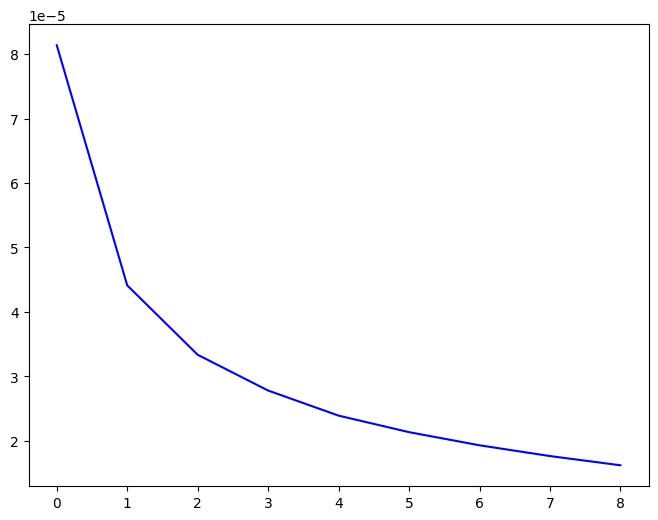

In [10]:
def plot_loss():
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_hist[1:], 'b')
plot_loss()

In [11]:
def jaccard_dist(embedding1, embedding2):
    return 1 - np.sum(np.minimum(embedding1, embedding2)) / np.sum(np.maximum(embedding1, embedding2)) 
    
def pair_dist(fp, N, embedding_fp, dist_fp):
    seq = torch.zeros((N, 4, SEQ_LEN))
    cnt = 0
    seq_ids = []
    with open(fp) as f:
        while True:
            next_n = list(islice(f, 2))
            if not next_n:
                break
            seq_id = next_n[0].strip()[1:]
            read = next_n[1].strip()
            seq_ids.append(seq_id)
            for i, c in enumerate(read):
                seq[cnt, atcg_map.get(c, 0), i] = 1.0
            cnt += 1
    embeddings = net.forward_one_side(Variable(seq)).data.numpy()
    embeddings.tofile(embedding_fp, sep=',', format='%.4e')
    with open(dist_fp, 'w') as fo:
        for i in range(N):
            for j in range(N):
                if i < j:
                    fo.write('{}-{}\t{:.4f}\n'.format(
                        seq_ids[i], seq_ids[j],
                        jaccard_dist(embeddings[i],
                                     embeddings[j])))

In [12]:
def my_plot(align_dist_df, x_dist_df, save_fp):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.tick_params(axis='both', which='major', labelsize=15)
    vmin = align_dist_df[1].min()
    vmax = align_dist_df[1].max()
    percentile = 99

    hb = ax.hexbin(
        align_dist_df[1],
        x_dist_df[1],
        gridsize=200,
        bins='log',
        cmap='Blues',
        extent=(0, 1, 0, 1),
        norm=plt.Normalize(vmin=np.percentile(align_dist_df[1], 100 - percentile),
                           vmax=np.percentile(align_dist_df[1], percentile))
    )

    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'r')
    ax.set_xlabel('alignment distance', fontsize=20)
    ax.set_ylabel('SENSE', fontsize=20)

    cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar_ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('log10(count + 1)', fontsize=20)
    fig.savefig(save_fp, bbox_inches='tight')   

/var/folders/x1/5w3j86893bg8f65k7gjw6jq00000gn/T/ipykernel_1582/590282352.py:8: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  hb = ax.hexbin(


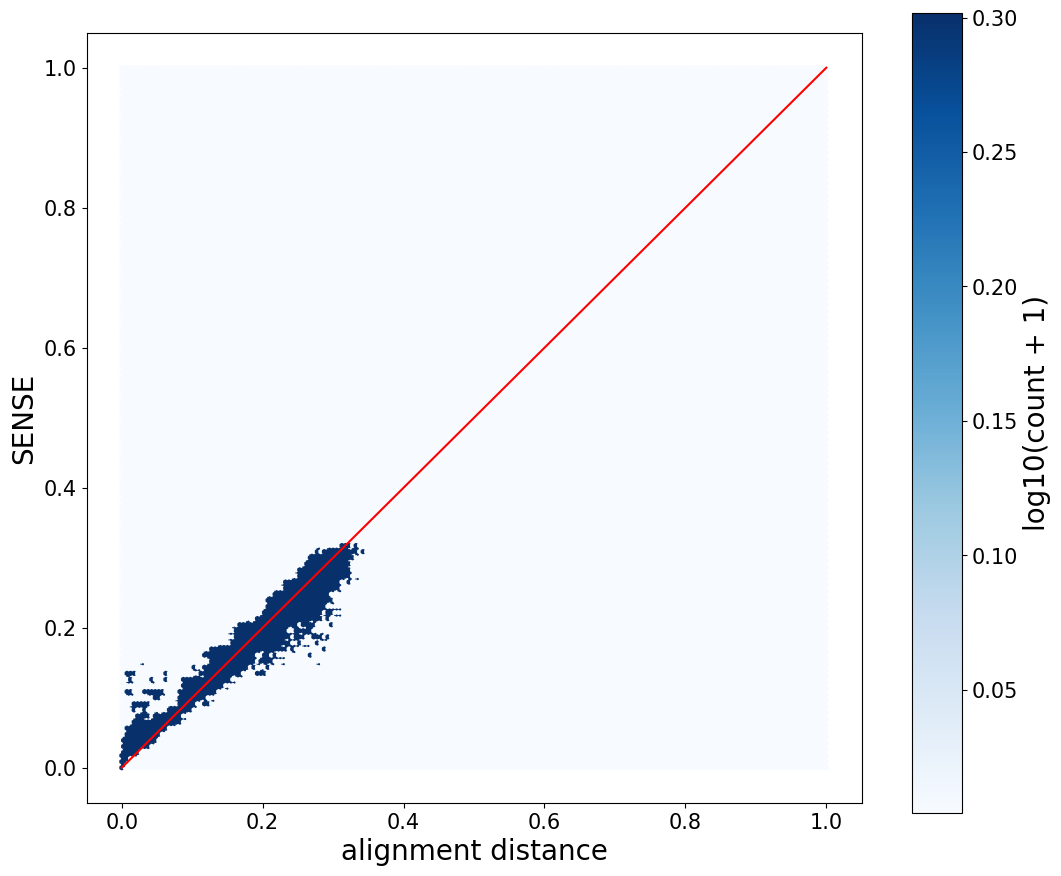

In [13]:
# evaluation
NUM_EVAL_N = 500 # number of eval pairs is N*(N-1)/2
pair_dist('./demo/eval.fa', NUM_EVAL_N, './demo/embeddings.txt', './demo/embeddings_dist.txt')
nw_df = pd.read_csv('./demo/eval_dist.txt', sep='\t', header=None)
my_df = pd.read_csv('./demo/embeddings_dist.txt', sep='\t', header=None)
my_plot(nw_df, my_df, save_fp='./demo/demo.png')


In [14]:
def tensor_to_atcg(tensor):
    atcg = "ATCG"
    return "".join([atcg[i] for i in tensor.argmax(dim=0)])

In [16]:
#Brute force con pairwise -Funziona
import time
import csv

csv_data = []

start_vero = time.time()
fasta = './demo/pair_shuffle.fa'
sequences = [str(record.seq) for record in SeqIO.parse(fasta, "fasta")]
#sequences = random.sample(all_sequences, 500)
#print(len(sequences))

# Effettua l'allineamento per ogni sequenza rispetto a tutte le altre sequenze
#for i in range(len(sequences)):
for i in range(60):
    start_time = time.time()
    seq1_embedding = net.get_embedding(sequences[i])

    # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
    best_score = float('inf')  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
    best_sequence = ""
    best_sequence_index = -1

    for j in range(60):
        if i != j:  # Evita di confrontare una sequenza con se stessa
            seq2_embedding = net.get_embedding(sequences[j])

            maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

            # Calcola la distanza di allineamento
            alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

            # Aggiorna il punteggio migliore e la sequenza corrispondente se necessario
            if alignment_distance < best_score:
                best_score = alignment_distance
                best_sequence = sequences[j]
                best_sequence_index = j + 1  # Indice + 1 per ottenere il numero di sequenza

    # Ottieni l'allineamento tra la sequenza corrente e quella migliore
    alignment = pairwise2.align.globalxx(sequences[i], best_sequence, one_alignment_only=True)[0]
    formatted_alignment = pairwise2.format_alignment(*alignment)


    # Calcola la percentuale del numero di sequenza rispetto al totale
    percentage = (best_sequence_index / len(sequences)) * 100

    # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
    print(f"Per la sequenza {i + 1}:")
   
    print(f"Miglior punteggio di allineamento: {best_score}")
    print(i)
    print(f"Sequenza corrispondente: {best_sequence}")
    print(f"Numero di sequenza corrispondente: {best_sequence_index} su {len(sequences)} (percentuale: {percentage:.2f}%)")
    print(f"Allineamento:")
    print(formatted_alignment)
    csv_data.append([i+1, best_sequence_index, best_sequence])
    end_time = time.time()
    tempo_effettivo = end_time - start_time
    print(tempo_effettivo)

# Scrivi i risultati in un file csv
with open('bruteforce.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['index', 'best_sequence_index', 'best_sequence'])
    writer.writerows(csv_data)

tempo_finale = time.time() - start_vero
print(tempo_finale)
print()

Per la sequenza 1:
CCTACGGGGGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCAGGGAAGAAAAGGATAGGGTTAATACCCCTGTCTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGTTCATGCTCGAAAGCGTGGGTAGCAAACAGGATTAGATACCCCAGTAGTC
Miglior punteggio di allineamento: 0.6939589977264404
0
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGGG

Per la sequenza 4:
CCTACGGGTGGCTGCAGTGGGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGCAGGGGACGAAAACCGGGTTTGAGAACATTGAGCCTGGGTGACGGTACCTTGCGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGGCTGGCAAGTCCATCTTAAAAGTGCGGGGCTCAACCCCGTGAGGGGATGGAAACTGGCAGTCTTGAGTGTAGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGTAACTGACGCTGAGGTTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCTGGTAGTC
Miglior punteggio di allineamento: 0.7231216430664062
3
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTAGCGAGGAAGGCATTTAGTTTAATAGACTAGGTGATTGACGTTAACTACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGG

Per la sequenza 7:
CCTACGGGGGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAGCTCTTTTGTTGGGAAAGAAAAGATTCGGGCTAATACCCTGGATTAATGACGGTACCCAAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTGTGTAAGTCAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGAGACTGTGCGACTAGAGGATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCTATAACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCGGGTAGTC
Miglior punteggio di allineamento: 0.7286250591278076
6
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGCCGGGGACGAATGTAGGCAGTGCGAACAGCATTGTGTAATGACGGTACCCGGCGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGGCGAGTAAGTCTTTCTTAAAAGTGCGGGGCTCAACCCCGTGAGGGGAGAGAAACTACTCATCTTGAGTGCAGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGATTGTAACTGACGCTGAGGCTCGAAAGCCAGG

Per la sequenza 10:
CCTACGGGCGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGGTGTAAAGCTCTGTTAATCGGGACGAAAGGCCTTCTTGCGAATAGTGAGAAGGATTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCCAATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCAGTAGTC
Miglior punteggio di allineamento: 0.7094327807426453
9
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGCG

Per la sequenza 13:
CCTACGGGTGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAACTCTGTGATCCGGGACGAAAAGGCAGAGTGCGAAGAACAAACTGCATTGACGGTACCGGAAAAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCCCAAGTCCCTCTTAAAAGTGCGGGGCTTAACCCCGTGATGGGAAGGAAACTGGGAAGCTGGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCGGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTC
Miglior punteggio di allineamento: 0.72020024061203
12
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGCGG

Per la sequenza 16:
CCTACGGGAGGCAGCAGTAGGGAATCTTCGGCAATGGACGGAAGTCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCATAAAGCTCTGTTGTAAGAGAAGAACGAGTGTGAGAGTGGAAAGTTCACACTGTGACGGTATCTTACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGCTTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCGTGTAGTC
Miglior punteggio di allineamento: 0.7135093808174133
15
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 19:
CCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTTAATCGGGACGAATGGTTCTTGTGCAAATAGTGCGAGGATTTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATTGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGAATGGAAACTGCCAATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCGGGTAGTC
Miglior punteggio di allineamento: 0.7109807133674622
18
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCAGGGAAGAAAAGGATAGGGTTAATACCCCTGTCTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGTTCATGCTCGAAAGCGT

Per la sequenza 22:
CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTTAATCGGGACGAAAGGCCTTCTTGCGAATAGTTAGAAGGATTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATCAGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCTGATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAACACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCGAGTAGTC
Miglior punteggio di allineamento: 0.7128711938858032
21
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 25:
CCTACGGGTGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCAGGGAAGAAAAGGCTGTTGCTAATACCGACAGCTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGTTCATGCTCGAAAGCGTGGGTAGCAAACAGGATTAGATACCCCTGTAGTC
Miglior punteggio di allineamento: 0.6915594339370728
24
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAG

Per la sequenza 28:
CCTACGGGCGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTTAATCGGGACGAAAGGCCTTCTTGCAAATAGTGAGAAGGATTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATCAGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGCGATGGGATGGAAACTGCTGATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGATGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCTAGTAGTC
Miglior punteggio di allineamento: 0.704230546951294
27
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGCG

Per la sequenza 31:
CCTACGGGGGGCAGCAGTGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTAGCGAGGAAGGCATTTAGTTTAATAGACTAGGTGATTGACGTTAACTACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCCTGTAGTC
Miglior punteggio di allineamento: 0.684953510761261
30
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGG

Per la sequenza 34:
CCTACGGGGGGCAGCAGTAGGGAATCTTCGGCAATGGGGGGAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTTAAGGAAGAACGAGTGTGAGAATGGAAAGTTCATACTGTGACGGTACTTAACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCAGTGGCTCAACCATTGTAGGCTTTGGAAACTGTTTAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCTGGTAGTC
Miglior punteggio di allineamento: 0.7078844904899597
33
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 37:
CCTACGGGTGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCAGGGAAGAAAAGGCTGTTGCTAATACCGACAGCTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGTTCATGCTCGAAAGCGTGGGTAGCAAACAGGATTAGATACCCCTGTAGTC
Miglior punteggio di allineamento: 0.6915594339370728
36
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAG

Per la sequenza 40:
CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGCAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGAAGGGGACGAACGTATATAGTGCGAATAGTGCTGTGTAATGACGGTACCTTTTGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGAGCGCAGGCGGCCATGTAAGTCTTGCTTAAAAGTTCGGGGCTCAACCCCGTGATGGGCAAGAAACTATATGGCTTGAGTGCAGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGCAACTGACGCTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCTTGTAGTC
Miglior punteggio di allineamento: 0.7200490236282349
39
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCAGGGAAGAAAAGGATAGGGTTAATACCCCTGTCTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGTTCATGCTCGAAAGCGT

Per la sequenza 43:
CCTACGGGTGGCAGCAGTAGGGAATCTTCGGCAATGGGGGGAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTTAGGGAAGAACGAGTGTGAGAATGTAAAGTTCATACTGTGACGGTACTTAACCAGAAAGGGACGACTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGAAAAGTCTGAAGTGAAAGGCAGTGGCTCAACCATTGTAGGCTTTGGAAACTGTTTAACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCTGGTAGTC
Miglior punteggio di allineamento: 0.7113519906997681
42
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 46:
CCTACGGGAGGCAGCAGTGGGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGCACGGGACGAAAACCGGGTTTGAGAATATTGAACATGGGTGACGGTACCGAGCGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGACATATAAGTCCATCTTAAAAGTGCGGGGCTCAACCCCGTGAGGGGATGGAAACTGTATGCCTTGAGTGCAGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGTAACTGACGCTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCTAGTAGTC
Miglior punteggio di allineamento: 0.717507541179657
45
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTAGCGAGGAAGGCATTTAGTTTAATAGACTAGGTGATTGACGTTAACTACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTG

Per la sequenza 49:
CCTACGGGAGGCAGCAGTAGGGAATCTTCGGCAATGGGGGCAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTAAGTCAAGAACGAGTGTGAGAGTGGAAAGTTCACACTGTGACGGTAGCTTACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGATTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTC
Miglior punteggio di allineamento: 0.7089115381240845
48
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 52:
CCTCGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTTAATCGGGACGAAAGGCCTTCTTGCGAATAGTGAGAAGGATTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCCAATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCGGTAGTC
Miglior punteggio di allineamento: 0.7089701890945435
51
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGCG

Per la sequenza 55:
CCTACGGGGGGCAGCAGTAGGGAATCTTCGGCAATGGGGGGAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTTAAGGAAGAACGAGTGTGAGAATGGAAAGTTCATACTGTGACGGTACTTAACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGAAAAGTCTGAAGTGAAAGGCAGTGGCTCAACCATTGTAGGCTTTGGAAACTGTTTAACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGGGGCTCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCCAGTAGTC
Miglior punteggio di allineamento: 0.7090404033660889
54
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

Per la sequenza 58:
CCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAACTCTGTGATCCGGGACGAAAAGGCAGAGTGCGAAGAACAAACTGCATTGACGGTACCGGAAAAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATTCCCAAGTCCCTCTTAAAAGTGCGGGGCTTAACCCCGTGATGGGAAGGAAACTGCGGAGCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCGAGGGGAGCGAACGGGATTAGATACCCTAGTAGTC
Miglior punteggio di allineamento: 0.7170736193656921
57
Sequenza corrispondente: CCTACGGGAGGCAGCAGGTAAGAATATTCCGCAATGGGGGGAACCCTGACGGAGCGACGCCGCGTGAACGAAGAAGGCCGGACGGTTGTAAAGTTCTTTTCTGTCCGAGGAATAAGTGTAGGAGGAAATGCCTGCATGGTGACGGTAGGGCAGGAATAAGCACCGGCTAATTACGTGCCAGCAGCCGCGGTAACACGTAAGGTGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGCAGGCGGGTCGCCAAGCTTGGTAAGAAATACCGGGGCTCAACTCCGGAGCTATATTGAGAACTGGCGAGCTAGAGTTGCCGAAGGGTATCCGGAATTCCGCGTGAAGGGGTGAAATCTGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGGATACCGGCGGACGACTGACGCTGAGGTGCGAAGGTGC

In [2]:
#allineamento genetico senza pairwise -Obsoleto
def global_alignment(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-1):
    len_seq1, len_seq2 = len(seq1), len(seq2)

    # Inizializza una matrice per memorizzare i punteggi dell'allineamento
    alignment_matrix = [[0] * (len_seq2 + 1) for _ in range(len_seq1 + 1)]

    # Inizializza la prima colonna e la prima riga
    for i in range(len_seq1 + 1):
        alignment_matrix[i][0] = i * gap_penalty

    for j in range(len_seq2 + 1):
        alignment_matrix[0][j] = j * gap_penalty

    # Calcola i punteggi dell'allineamento riempiendo la matrice
    for i in range(1, len_seq1 + 1):
        for j in range(1, len_seq2 + 1):
            match = alignment_matrix[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score)
            delete = alignment_matrix[i - 1][j] + gap_penalty
            insert = alignment_matrix[i][j - 1] + gap_penalty

            alignment_matrix[i][j] = max(match, delete, insert)

    # Risaliamo dalla fine della matrice per ricostruire l'allineamento
    aligned_seq1, aligned_seq2 = "", ""
    i, j = len_seq1, len_seq2

    while i > 0 or j > 0:
        current_score = alignment_matrix[i][j]

        if i > 0 and alignment_matrix[i - 1][j] + gap_penalty == current_score:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        elif j > 0 and alignment_matrix[i][j - 1] + gap_penalty == current_score:
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1
        else:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1

    return aligned_seq1, aligned_seq2
    
def format_alignment(seq1, seq2):
    line_length = 80  # Lunghezza massima della riga per facilitare la lettura
    lines = []
    for i in range(0, len(seq1), line_length):
            seq1_line = seq1[i:i + line_length]
            seq2_line = seq2[i:i + line_length]
    
            match_line = "".join("|" if base1 == base2 else " " for base1, base2 in zip(seq1_line, seq2_line))
    
            lines.append(f"{seq1_line}\n{match_line}\n{seq2_line}\n\n")
    
    return "".join(lines)

start1 = time.time()

# Inizializza il toolbox
toolbox = base.Toolbox()

# Leggi sequenze genomiche da un file FASTA
input_file = './converted/pair_shuffle.fa'
#num_sequences_to_select = 500

# Leggi tutte le sequenze dal file .fa
all_sequences = list(SeqIO.parse(input_file, "fasta"))

# Seleziona casualmente 500 sequenze
#selected_sequences = random.sample(all_sequences, num_sequences_to_select)
#print(len(selected_sequences))

current_sequence_index = 0

def generate_individual():
    global current_sequence_index
    if current_sequence_index + 1 >= len(all_sequences):
        # Se tutte le sequenze sono state utilizzate, reimposta l'indice
        current_sequence_index = 0

    # Seleziona due sequenze consecutive
    seq1 = str(all_sequences[current_sequence_index].seq)
    seq2 = str(all_sequences[current_sequence_index + 1].seq)

    # Incrementa l'indice per la prossima chiamata
    current_sequence_index += 2

    return [seq1, seq2]

"""

# Crea una funzione per generare una coppia di sequenze genomiche
def generate_individual():
return random.sample(all_sequences, 2)

"""

# Inizializza il toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
#toolbox.register("mate", crosseSubsequence)
toolbox.register("mutate", crosseSubsequence)
toolbox.register("select", tools.selTournament, tournsize=5)

net = SiameseNetwork()

def crosseSubsequence(individual):
    # Seleziona due sequenze casuali dall'individuo
    seq1, seq2 = individual[0][0],individual[0][1]

    # Esegui il crossover (definisci la tua logica di crossover)
    start_position = random.randint(0, min(len(seq1), len(seq2)) - 1)
    subset_size = random.randint(1, min(len(seq1) - start_position, len(seq2) - start_position))

    # Scambia le sottosequenze tra seq1 e seq2
    seq1_mutated = seq1[:start_position] + seq2[start_position:start_position + subset_size] + seq1[start_position + subset_size:]
    seq2_mutated = seq2[:start_position] + seq1[start_position:start_position + subset_size] + seq2[start_position + subset_size:]

    # Restituisci la coppia crossoverata come unico individuo
    return [seq1_mutated,seq2_mutated]
# Definisci la funzione di fitness che calcola la distanza tra le sequenze
def evaluate(individual):
    
    
    seq1, seq2 = individual[0][0],individual[0][1]# Ottieni le sequenze da SeqRecord
    seq1_embedding = net.get_embedding(seq1)
    seq2_embedding = net.get_embedding(seq2)
    maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)
    distance = maxout.sum(1) / minout.sum(1)
    return distance.item(),



# Imposta il numero di generazioni e la dimensione della popolazione
generations = 10
population_size = 200
popolazioni = 1
for i in range(popolazioni):
    print(f"\nRun {i + 1}:")
    # Esegui l'algoritmo genetico 10 volte
    for run in range(1):
        
        # Crea una popolazione iniziale
        pop = toolbox.population(n=population_size)
    
        # Esegui l'algoritmo genetico
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", min)
        op, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.2, mutpb=0.2, ngen=generations, stats=stats, halloffame=None, verbose=True)
        # Stampa la popolazione mutata alla fine di ogni generazione
        print(f"Generazione {gen + 1} - Popolazione Mutata:")
        for ind in pop:
            print(ind)
    
       # Stampa il miglior individuo per ogni generazione
        for gen in range(1):
            best_individual = tools.selBest(pop, 1)[0]
            best_fitness = best_individual.fitness.values[0]
            seq1, seq2 = best_individual
    
            print(f"Miglior Fitness = {best_fitness}")
            print(f"Miglior coppia di sequenze:")
            print(f"Seq1: {seq1.seq}")
            print(f"Seq2: {seq2.seq}")
            alignments = global_alignment(seq1.seq, seq2.seq)
            formatted_alignment = format_alignment(alignments[0],alignments[1])
            print(f"Allineamento:")
            print(formatted_alignment)
    
    print("\n-------------------------------------")

end1 = time.time()
delta = end1 - start1
print(delta)


NameError: name 'base' is not defined

In [1]:
#Brute force senza pairwise -Funziona per allineamento e lista ordinata
csv_data_1 = []

def global_alignment(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-1):
    len_seq1, len_seq2 = len(seq1), len(seq2)

    # Inizializza una matrice per memorizzare i punteggi dell'allineamento
    alignment_matrix = [[0] * (len_seq2 + 1) for _ in range(len_seq1 + 1)]

    # Inizializza la prima colonna e la prima riga
    for i in range(len_seq1 + 1):
        alignment_matrix[i][0] = i * gap_penalty

    for j in range(len_seq2 + 1):
        alignment_matrix[0][j] = j * gap_penalty

    # Calcola i punteggi dell'allineamento riempiendo la matrice
    for i in range(1, len_seq1 + 1):
        for j in range(1, len_seq2 + 1):
            match = alignment_matrix[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score)
            delete = alignment_matrix[i - 1][j] + gap_penalty
            insert = alignment_matrix[i][j - 1] + gap_penalty

            alignment_matrix[i][j] = max(match, delete, insert)

    # Risaliamo dalla fine della matrice per ricostruire l'allineamento
    aligned_seq1, aligned_seq2 = "", ""
    i, j = len_seq1, len_seq2

    while i > 0 or j > 0:
        current_score = alignment_matrix[i][j]

        if i > 0 and alignment_matrix[i - 1][j] + gap_penalty == current_score:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        elif j > 0 and alignment_matrix[i][j - 1] + gap_penalty == current_score:
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1
        else:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1

    return aligned_seq1, aligned_seq2
    
def format_alignment(seq1, seq2):
    line_length = 80  # Lunghezza massima della riga per facilitare la lettura
    lines = []
    for i in range(0, len(seq1), line_length):
            seq1_line = seq1[i:i + line_length]
            seq2_line = seq2[i:i + line_length]
    
            match_line = "".join("|" if base1 == base2 else " " for base1, base2 in zip(seq1_line, seq2_line))
    
            lines.append(f"{seq1_line}\n{match_line}\n{seq2_line}\n\n")
    
    return "".join(lines)

start_vero = time.time()
fasta = './demo/pair_shuffle.fa'
sequences_all = [str(record.seq) for record in SeqIO.parse(fasta, "fasta")]
sequences=sequences_all[:500]
print(len(sequences))

# Inizializza un insieme di sequenze utilizzate
used_sequences = set()

# Lista per tenere traccia della catena delle sequenze ordinate decrescenti
ordered_sequence_chain = []
iterazioni = 20
print(iterazioni)

for i in range(20):
    start_time = time.time()
    # Seleziona la sequenza corrente come punto di partenza
    current_sequence_index = 0
    current_2 = 1
    prima_sequenza = sequences[current_sequence_index]
    print(prima_sequenza)
    current_sequence = sequences[current_2]

    # Se la sequenza è già stata utilizzata, passa alla prossima iterazione
    if current_2 in used_sequences:
        continue

    start_time = time.time()

    # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
    best_score = 0  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
    best_sequence = ""
    best_sequence_index = -1

    for j in range(len(sequences)):
        if current_sequence_index != j and j not in used_sequences:
            seq1_embedding = net.get_embedding(prima_sequenza)
            seq2_embedding = net.get_embedding(sequences[j])

            maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

            alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

            if alignment_distance > best_score:
                best_score = alignment_distance
                best_sequence = sequences[j]
                best_sequence_index = j

    # Aggiungi la sequenza corrente all'insieme delle sequenze utilizzate
    used_sequences.add(current_sequence)

    # Rimuovi la sequenza corrispondente dalla lista delle sequenze totali
    sequences.pop(best_sequence_index)
    print(best_sequence_index)

    # Ottieni l'allineamento tra la sequenza corrente e quella migliore
    alignments = global_alignment(current_sequence, best_sequence)
    
    if alignments:
        alignment = alignments[0]
        formatted_alignment = format_alignment(alignments[0],alignments[1])

    # Calcola la percentuale del numero di sequenza rispetto al totale
    percentage = (best_sequence_index + 1) / len(sequences) * 100

    # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
    print(f"Per la sequenza {current_sequence_index + 1}:")
    print(f"Miglior punteggio di allineamento: {best_score}")
    print(f"Sequenza corrispondente: {best_sequence}")
    print(f"Numero di sequenza corrispondente: {best_sequence_index + 1} su {len(sequences)} (percentuale: {percentage:.2f}%)")
    print(f"Allineamento:")
    print(formatted_alignment)
    end_time = time.time()
    tempo_effettivo = end_time - start_time
    print(f"Tempo effettivo: {tempo_effettivo:.2f} secondi")
    csv_data_1.append([i+1, best_sequence_index, best_sequence])
    print()

    # Aggiungi la sequenza corrente alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(current_sequence)

    # Aggiungi la sequenza migliore alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(best_sequence)

tempo_finale = time.time() - start_vero
print(f"Tempo totale: {tempo_finale:.2f} secondi")
# Scrivi i risultati in un file csv
with open('bruteforce.csv', 'w', newline='') as csv_file:     
    writer = csv.writer(csv_file)
    writer.writerow(['index', 'best_sequence_index', 'best_sequence'])
    writer.writerows(csv_data_1)

# Stampa la catena delle sequenze ordinate decrescenti
print("Catena delle sequenze ordinate decrescenti:")
for idx, sequence in enumerate(ordered_sequence_chain):
    print(f"Sequenza {idx + 1}: {sequence}")
tempo_finale = time.time() - start_vero
print(tempo_finale)
print()


NameError: name 'time' is not defined

In [ ]:

def pair_dist(fp, N, embedding_fp, dist_fp):
    seq = torch.zeros((N, 4, SEQ_LEN))
    cnt = 0
    seq_ids = []
    with open(fp) as f:
        while True:
            next_n = list(islice(f, 2))
            if not next_n:
                break
            seq_id = next_n[0].strip()[1:]
            read = next_n[1].strip()
            seq_ids.append(seq_id)
            for i, c in enumerate(read):
                seq[cnt, atcg_map.get(c, 0), i] = 1.0
            cnt += 1
    embeddings = net.forward_one_side(Variable(seq)).data.numpy()
    embeddings.tofile(embedding_fp, sep=',', format='%.4e')
    with open(dist_fp, 'w') as fo:
        for i in range(N):
            for j in range(N):
                if i < j:
                    fo.write('{}-{}\t{:.4f}\n'.format(
                        seq_ids[i], seq_ids[j],
                        jaccard_dist(embeddings[i],
                                     embeddings[j])))



In [19]:
import csv
def confronta_sequenze(seq1, seq2):
    lunghezza = min(len(seq1), len(seq2))
    corrispondenze = sum(a == b for a, b in zip(seq1, seq2))
    percentuale_corrispondenza = (corrispondenze / lunghezza) * 100    
    return percentuale_corrispondenza
    
def leggi_csv(file_path):
    sequenze = {}    
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        header = next(csv_reader)
        for row in csv_reader:
            indice, _, sequenza = row            
            sequenze[indice] = sequenza
    return sequenze
    
file_brute = 'bruteforce.csv'
file_genetic = 'genetico.csv'
output_file = 'risultati_confronto.csv'
sequenze_brute = leggi_csv(file_brute)
sequenze_genetic = leggi_csv(file_genetic)
risultati = []
for indice in sequenze_brute:
    if indice in sequenze_genetic:
        seq_brute = sequenze_brute[indice]
        seq_genetic = sequenze_genetic[indice]
        percentuale = confronta_sequenze(seq_brute, seq_genetic)
        risultati.append((indice, percentuale))

with open(output_file, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(['indice', 'percentuale_corrispondenza'])
    csv_writer.writerows(risultati)
   
print(f'Risultati salvati in: {output_file}')
percentuali_totali = [percentuale for _, percentuale in risultati]
percentuale_totale_media = sum(percentuali_totali) /len(percentuali_totali) if percentuali_totali else 0
print(f'Percentuale totale media: {percentuale_totale_media:.2f}%')

Risultati salvati in: risultati_confronto.csv
Percentuale totale media: 37.70%


In [17]:
with open('log_file.txt', 'w') as log_file:
    def generate_individual_randomly(all_sequences):
        if len(all_sequences) < 2:
            raise ValueError("Not enough sequences to generate an individual")

        # Randomly select two distinct sequences
        chosen_indices = random.sample(range(len(all_sequences)), 2)
        seq1, seq2 = all_sequences[chosen_indices[0]], all_sequences[chosen_indices[1]]

        # Remove the chosen sequences by their unique identifiers
        all_sequences[:] = [seq for i, seq in enumerate(all_sequences) if i not in chosen_indices]

        return [seq1, seq2]

    def count_occurrences(sequence):
        index_counts = {}

        for index in sequence:
            if index in index_counts:
                index_counts[index] += 1
            else:
                index_counts[index] = 1

        max_occurrences = {}
        for index, count in index_counts.items():
            if index not in max_occurrences or count > max_occurrences[index]:
                max_occurrences[index] = count

        return max_occurrences

    def initialize_origin_arrays(individual):
        seq1, seq2 = individual
        origin_array1 = [seq1.id] * len(seq1.seq)
        origin_array2 = [seq2.id] * len(seq2.seq)
        return origin_array1, origin_array2


    def crossover_subsequence(population, origin_arrays):
        new_population = []  # Creare una nuova lista per gli individui modificati
        print(len(population))
        for i in range(2):
            indici_usati = list(range(len(population)))
            while len(indici_usati) >= 2:
                # Seleziona due individui casuali dalla popolazione
                ind1_idx = random.choice(indici_usati)
                print("indice 1 del crossover", file=log_file)
                print(ind1_idx, file=log_file)
                indici_usati.remove(ind1_idx)
                ind2_idx = random.choice(indici_usati)
                print("indice 2 del crossover", file=log_file)
                print(ind2_idx, file=log_file)
                indici_usati.remove(ind2_idx)
                print("popolazione è lunga", file=log_file)
                print(len(population), file=log_file)
                seq1_1, seq1_2 = population[ind1_idx]
                seq2_1, seq2_2 = population[ind2_idx]
                print("origin array è lung0", file=log_file)
                print(len(origin_arrays), file=log_file)
                origin_array1_1, origin_array1_2 = origin_arrays[ind1_idx]
                origin_array2_1, origin_array2_2 = origin_arrays[ind2_idx]
                print(origin_array1_1, file=log_file)
                print(origin_array1_2, file=log_file)
                print(origin_array2_1, file=log_file)
                print(origin_array2_2, file=log_file)

                # Applica la tua logica di crossover ai due individui selezionati
                start_position1 = random.randint(0, len(seq1_1.seq))
                #print("posizione di start1")
                #print(start_position1)
                # Imposta subset_size1 dalla posizione di start fino alla fine della sequenza
                subset_size1 = len(seq1_1.seq) - start_position1
                #print(subset_size1)


                subset_seq1_1 = seq1_1.seq[start_position1:start_position1 + subset_size1]
                subset_seq1_2 = seq1_2.seq[start_position1:start_position1 + subset_size1]

                subset_seq2_1 = seq2_1.seq[start_position1:start_position1 + subset_size1]
                subset_seq2_2 = seq2_2.seq[start_position1:start_position1 + subset_size1]
                # Trasforma le sequenze in oggetti SeqRecord con le sequenze modificate
                seq1_1_mutated = SeqRecord(Seq(str(seq1_1.seq[:start_position1]) + str(subset_seq2_1) + str(seq1_1.seq[start_position1 + subset_size1:])))
                seq1_2_mutated = SeqRecord(Seq(str(seq1_2.seq[:start_position1]) + str(subset_seq2_2) + str(seq1_2.seq[start_position1 + subset_size1:])))
                #print("sequenza 1 mutata")
                new_origin_array1_1 = origin_array1_1[:start_position1] + origin_array2_1[start_position1:start_position1 + subset_size1] + origin_array1_1[start_position1 + subset_size1:]
                new_origin_array1_2 = origin_array1_2[:start_position1] + origin_array2_2[start_position1:start_position1 + subset_size1] + origin_array1_2[start_position1 + subset_size1:]
                #print(seq1_mutated.seq)
                seq2_1_mutated = SeqRecord(Seq(str(seq2_1.seq[:start_position1]) + str(subset_seq1_1) + str(seq2_1.seq[start_position1 + subset_size1:])))
                seq2_2_mutated = SeqRecord(Seq(str(seq2_2.seq[:start_position1]) + str(subset_seq1_2) + str(seq2_2.seq[start_position1 + subset_size1:])))
                #print("sequenza 2 mutata")
                new_origin_array2_1 = origin_array2_1[:start_position1] + origin_array1_1[start_position1:start_position1 + subset_size1] + origin_array2_1[start_position1 + subset_size1:]
                new_origin_array2_2 = origin_array2_2[:start_position1] + origin_array1_2[start_position1:start_position1 + subset_size1] + origin_array2_2[start_position1 + subset_size1:]
                print("\n-------------------------------------")
                print("nuovo array 1_1", file=log_file)
                print(new_origin_array1_1, file=log_file)
                print("\n-------------------------------------")
                print("nuovo array 2_1", file=log_file)
                print(new_origin_array2_1, file=log_file)
                print("\n-------------------------------------")
                print("nuovo array 1_2", file=log_file)
                print(new_origin_array1_2, file=log_file)
                print("\n-------------------------------------")
                print("nuovo array 2_2", file=log_file)
                print(new_origin_array2_2, file=log_file)
                print("\n-------------------------------------")

                # Aggiungi gli individui mutati alla nuova popolazione
                nuovasequenza1 = (seq1_1_mutated, seq1_2_mutated)
                nuovasequenza2 = (seq2_1_mutated, seq2_2_mutated)

                new_population.append(nuovasequenza1)
                new_population.append(nuovasequenza2)

                origin_arrays[ind1_idx] = new_origin_array1_1, new_origin_array1_2
                origin_arrays[ind2_idx] = new_origin_array2_1, new_origin_array2_2

        print("\n FINE CROSSOVER -------------------------------------", file=log_file)
        print(len(new_population), file=log_file)
        return new_population, origin_arrays


    #%%
    def mutation_subsequence(population, origin_arrays):
        new_population = population  # Creare una nuova lista per gli individui modificati
        new_origin_array = origin_arrays
        num_to_mutate = len(population)

        indici = list(range(len(population)))

        mutated_count = 0  # Contatore per gli individui mutati
        print(len(indici))
        while mutated_count < num_to_mutate:
            # Seleziona due individui casuali dalla popolazione
            ind1_idx = random.choice(indici)
            indici.remove(ind1_idx)
            ind2_idx = random.choice(indici)
            indici.remove(ind2_idx)
            print("indici usati rimanenti", file=log_file)
            print(len(indici), file=log_file)
            print("individui mutati", file=log_file)
            print(mutated_count, file=log_file)

            print("indice 1", file=log_file)
            print(ind1_idx, file=log_file)
            print("indice 2", file=log_file)
            print(ind2_idx, file=log_file)
            seq1_1, seq1_2 = population[ind1_idx]
            seq2_1, seq2_2 = population[ind2_idx]
            origin_array1_1, origin_array1_2 = origin_arrays[ind1_idx]
            print("array originale 1_1", file=log_file)
            print(origin_array1_1, file=log_file)
            print("array originale 1_2", file=log_file)
            print(origin_array1_2, file=log_file)
            origin_array2_1, origin_array2_2 = origin_arrays[ind2_idx]
            print("array originale 2_1", file=log_file)
            print(origin_array2_1, file=log_file)
            print("array originale 2_2", file=log_file)
            print(origin_array2_2, file=log_file)

            # Applica la tua logica di crossover ai due individui selezionati
            start_position1 = random.randint(0, len(seq1_1.seq)-1)
            #print("posizione di start1")
            #print(start_position1)
            min_size = 150
            if SEQ_LEN - start_position1 < 100:
                min_size = SEQ_LEN - start_position1

            # subset_size1 = random.randint(min_size, max_size)
            subset_size1 = min_size
            # Imposta subset_size1 dalla posizione di start fino alla fine della sequenza
            #subset_size1 = random.randint(1, (len(seq1_1.seq) - start_position1))
            #print(subset_size1)

            numero_casuale = random.randint(0, 1)
            print("è stato generato il numero:")
            print(numero_casuale)
            if (numero_casuale == 0):
                subset_seq1_1 = seq1_1.seq[start_position1:start_position1 + subset_size1]
                subset_seq2_1 = seq2_1.seq[start_position1:start_position1 + subset_size1]
                seq1_1_mutated = SeqRecord(Seq(str(seq1_1.seq[:start_position1]) + str(subset_seq2_1) + str(seq1_1.seq[start_position1 + subset_size1:])))
                new_origin_array1_1 = origin_array1_1[:start_position1] + origin_array2_1[start_position1:start_position1 + subset_size1] + origin_array1_1[start_position1 + subset_size1:]
                seq2_1_mutated = SeqRecord(Seq(str(seq2_1.seq[:start_position1]) + str(subset_seq1_1) + str(seq2_1.seq[start_position1 + subset_size1:])))
                new_origin_array2_1 = origin_array2_1[:start_position1] + origin_array1_1[start_position1:start_position1 + subset_size1] + origin_array2_1[start_position1 + subset_size1:]
                print("nuovo array 1_1", file=log_file)
                print(new_origin_array1_1, file=log_file)
                print("nuovo array 2_1", file=log_file)
                print(new_origin_array2_1, file=log_file)
                nuovasequenza1 = (seq1_1_mutated, seq1_2)
                nuovasequenza2 = (seq2_1_mutated, seq2_2)

                new_population[ind1_idx] = nuovasequenza1
                new_population[ind2_idx] = nuovasequenza2
                new_array1 = (new_origin_array1_1, origin_array1_2)
                new_array2 = (new_origin_array2_1, origin_array2_2)
                origin_arrays[ind1_idx] = (new_array1)
                origin_arrays[ind2_idx] = (new_array2)
                """
                new_population.append(nuovasequenza1)
                new_population.append(nuovasequenza2)
                new_array1 = (new_origin_array1_1, origin_array1_2)
                new_array2 = (new_origin_array2_1, origin_array2_2)
                new_origin_array.append(new_array1)
                new_origin_array.append(new_array2)
                """
                mutated_count += 2  # Aggiorna il contatore per gli individui mutati
            else:
                subset_seq1_2 = seq1_2.seq[start_position1:start_position1 + subset_size1]
                subset_seq2_2 = seq2_2.seq[start_position1:start_position1 + subset_size1]
                # Trasforma le sequenze in oggetti SeqRecord con le sequenze modificate
                seq1_2_mutated = SeqRecord(Seq(str(seq1_2.seq[:start_position1]) + str(subset_seq2_2) + str(seq1_2.seq[start_position1 + subset_size1:])))
                #print("sequenza 1 mutata")
                new_origin_array1_2 = origin_array1_2[:start_position1] + origin_array2_2[start_position1:start_position1 + subset_size1] + origin_array1_2[start_position1 + subset_size1:]
                #print(seq1_mutated.seq)
                seq2_2_mutated = SeqRecord(Seq(str(seq2_2.seq[:start_position1]) + str(subset_seq1_2) + str(seq2_2.seq[start_position1 + subset_size1:])))
                #print("sequenza 2 mutata")
                new_origin_array2_2 = origin_array2_2[:start_position1] + origin_array1_2[start_position1:start_position1 + subset_size1] + origin_array2_2[start_position1 + subset_size1:]
                print("nuovo array 1_2", file=log_file)
                print(new_origin_array1_2, file=log_file)
                print("nuovo array 2_2", file=log_file)
                print(new_origin_array2_2, file=log_file)
                nuovasequenza1 = (seq1_1, seq1_2_mutated)
                nuovasequenza2 = (seq1_2, seq2_2_mutated)

                new_population[ind1_idx] = nuovasequenza1
                new_population[ind2_idx] = nuovasequenza2
                new_array1 = (origin_array1_1, new_origin_array1_2)
                origin_arrays[ind1_idx] = (new_array1)
                new_array2 = (origin_array2_1, new_origin_array2_2)
                origin_arrays[ind2_idx] = (new_array2)
                """
                new_population.append(nuovasequenza1)
                new_population.append(nuovasequenza2)
                new_array1 = (origin_array1_1, new_origin_array1_2)
                new_origin_array.append(new_array1)
                new_array2 = (origin_array2_1, new_origin_array2_2)
                new_origin_array.append(new_array2)
                """
                mutated_count += 2  # Aggiorna il contatore per gli individui mutati

            print("\n FINE MUTAZIONE -------------------------------------", file=log_file)
        print(len(new_population), file=log_file)
        return new_population, new_origin_array

    csv_data = []

    def confronta_sequenze(seq1, seq2):
        lunghezza_minima = min(len(seq1), len(seq2))
        caratteri_comuni = sum(c1 == c2 for c1, c2 in zip(seq1, seq2))
        percentuale_somiglianza = (caratteri_comuni / lunghezza_minima) * 100
        return percentuale_somiglianza

    def evaluate(individual, net):
        seq1, seq2 = individual
        seq1_embedding = net.get_embedding(seq1)
        seq2_embedding = net.get_embedding(seq2)
        maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)
        distance = maxout.sum(1) / minout.sum(1)
        return distance.item(),


    def evaluate_individual(individual, net, origin_array):
        """
        Valuta la fitness media di un individuo basata sulle sottoporzioni identificate
        in origin_array.

        :param individual: Una tupla contenente le due sequenze dell'individuo.
        :param net: La rete neurale Siamese addestrata.
        :param origin_array: L'array che traccia l'origine delle sottoporzioni della sequenza.
        :return: La fitness media dell'individuo.
        """
        seq1, seq2 = individual
        weighted_fitness = 0
        total_length = 0

        current_origin = origin_array[0]
        start_index = 0
        for i, origin in enumerate(origin_array + ['']):  # Aggiunge un elemento per forzare l'ultima valutazione
            if origin != current_origin or i == len(origin_array):
                segment_length = i - start_index
                total_length += segment_length

                # Estrai la sottosequenza
                subseq1 = seq1.seq[start_index:i]
                subseq2 = seq2.seq[start_index:i]

                # Calcola la fitness della sottosequenza
                seq1_embedding = net.get_embedding(subseq1)
                seq2_embedding = net.get_embedding(subseq2)
                maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)
                distance = 1 - (minout.sum(1) / maxout.sum(
                    1)).item()  # Ad esempio, utilizza la distanza di Jaccard inversa come fitness

                # Applica il peso basato sulla lunghezza della sottosequenza
                weighted_fitness += distance * segment_length

                start_index = i
                current_origin = origin

        # Calcola la fitness media pesata
        average_weighted_fitness = weighted_fitness / total_length if total_length > 0 else 0

        return average_weighted_fitness

    def update_sequence_id(sequence, new_id):
        sequence.id = str(new_id)


    def generate_random_dna_sequence(length):
        bases = ['A', 'T', 'C', 'G']
        return ''.join(random.choice(bases) for _ in range(length))


    def save_fasta_file(filename, sequences):
        with open(filename, 'w') as file:
            for i, sequence in enumerate(sequences, start=1):
                file.write(f">Sequence{i}\n")
                file.write(sequence + '\n')


    num_sequences = 40
    sequence_length = 155
    input_file = [generate_random_dna_sequence(sequence_length) for _ in range(num_sequences)]
    save_fasta_file('random_sequences.fasta', input_file)
    print(f"{num_sequences} random DNA sequences of length {sequence_length} saved to 'random_sequences.fasta'.", file=log_file)
    # Leggi sequenze genomiche da un file FASTA
    # input_file = './demo/pair_shuffle.fa'
    input_file = 'random_sequences.fasta'
    all_sequences = list(SeqIO.parse(input_file, "fasta"))
    for i, seq in enumerate(all_sequences):
            update_sequence_id(seq, i)

    start_time = time.time()
    current_sequence_index = 0
    # Imposta il numero di generazioni e la dimensione della popolazione
    generations = 500
    population_size = 20

    # Esegui l'algoritmo genetico
    for run in range(1):
        print(f"\nRun {run + 1}:")
        # Crea una popolazione iniziale
        population = [generate_individual_randomly(all_sequences) for _ in range(population_size)]
        pop2 = population
        # Riassegnazione degli ID
        new_id = 0
        for individual in population:
            for seq in individual:
                seq.id = str(new_id)
                new_id += 1
        id_to_index_map = {seq.id: i for i, pair in enumerate(population) for seq in pair}
        origin_arrays = [initialize_origin_arrays(individual) for individual in population]
        print("lunghezza pop appena creata", file=log_file)
        print(len(population), file=log_file)
        print("lunghezza origin array appena creati", file=log_file)
        print(len(origin_arrays), file=log_file)
        for gen in range(generations):
            # Crea nuovi individui attraverso crossover e mutazione
            # numero1 = random.randint(0, 1)
            numero1 = 1
            # numero2 = random.randint(0, 1)
            numero2 = 1
            if numero1 == numero2:
                print("STA AVVENENDO LA MUTAZIONE", file=log_file)
                population, origin_arrays = mutation_subsequence(population, origin_arrays)
                fitness_values = [evaluate_individual(individual, net, origin_arrays) for individual in population]
                for i, (fitness, (seq1, seq2)) in enumerate(zip(fitness_values, population)):
                    print(f"Per l'accoppiamento {i + 1} composto dalla sequenza {seq1.seq} e dalla sequenza {seq2.seq} la fitness è: {fitness}", file=log_file)
                print("lunghezza pop dopo mutazione", file=log_file)
                print(len(population), file=log_file)
                print("lunghezza origin array dopo mutazione", file=log_file)
                print(len(origin_arrays), file=log_file)
            else:
                print("nessuna mutazione")
            print(len(population))
            print("ESEGUO IL CROSSOVER", file=log_file)
            population, origin_arrays = crossover_subsequence(population, origin_arrays)
            """
            for arr in origin_arrays:
                print(len(population), file=log_file)
            """
            # Valuta la fitness degli individui
            fitness_values = [evaluate_individual(individual, net, origin_arrays) for individual in population]
            for i, (fitness, (seq1, seq2)) in enumerate(zip(fitness_values, population)):
                print(f"Per l'accoppiamento {i + 1} composto dalla sequenza {seq1.seq} e dalla sequenza {seq2.seq} la fitness è: {fitness}", file=log_file)

            best_individuals_data = sorted(zip(population, origin_arrays, fitness_values), key=lambda x: x[2], reverse=True)[:population_size]
            best_individuals = [ind for ind, _, _ in best_individuals_data]
            best_origin_arrays = [origin for _, origin, _ in best_individuals_data]
            population = best_individuals
            origin_arrays = best_origin_arrays
            print(len(population))
            for pop in population:
                print(pop, file=log_file)

            for arr in origin_arrays:
                print(origin_arrays, file=log_file)

        print("\n-------------------------------------", file=log_file)

    # Converti la popolazione bidimensionale in una lista unidimensionale
    pop2 = [sequence for pair in pop2 for sequence in pair]
    j = 1
    for i in range(len(origin_arrays)):
        print(f"Array numero {i + 1}:")
        array1, array2 = origin_arrays[i]

        max_occurrences1 = count_occurrences(array1)
        max_occurrences2 = count_occurrences(array2)

        max_index1 = max(max_occurrences1, key=max_occurrences1.get)
        max_index2 = max(max_occurrences2, key=max_occurrences2.get)

        total_occurrences1 = sum(max_occurrences1.values())
        total_occurrences2 = sum(max_occurrences2.values())

        max_value1 = max_occurrences1[max_index1]
        max_value2 = max_occurrences2[max_index2]

        percentage1 = (max_value1 / total_occurrences1) * 100
        percentage2 = (max_value2 / total_occurrences2) * 100

        max_index1_mapped = id_to_index_map[str(max_index1)]
        max_index2_mapped = id_to_index_map[str(max_index2)]
        j+=2
        print("\n------------------")


    # Scrivi i risultati in un file csv
    with open('genetico.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['index', 'best_sequence_index', 'best_sequence'])
        writer.writerows(csv_data)

    # Calcola il tempo di esecuzione
    end_time = time.time()
    execution_time = end_time - start_time

    start_bruto = time.time()
    csv_data2 = []
    print(len(pop2))
    popolazione_brutta = pop2.copy()
    print(len(popolazione_brutta))

    for i in range(20):
        start_time = time.time()
        seq1_embedding = net.get_embedding(popolazione_brutta[i])

        # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
        best_score = float('inf')  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
        best_sequence = ""
        best_sequence_index = -1

        for j in range(20):
            if i != j:  # Evita di confrontare una sequenza con se stessa
                seq2_embedding = net.get_embedding(popolazione_brutta[j])

                maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

                # Calcola la distanza di allineamento
                alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

                # Aggiorna il punteggio migliore e la sequenza corrispondente se necessario
                if alignment_distance < best_score:
                    best_score = alignment_distance
                    best_sequence = popolazione_brutta[j].seq
                    best_sequence_index = j + 1  # Indice + 1 per ottenere il numero di sequenza

        # Calcola la percentuale del numero di sequenza rispetto al totale
        percentage = (best_sequence_index / len(popolazione_brutta)) * 100

        # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
        print(f"Per la sequenza {i + 1}:", file=log_file)
        print(f"Miglior punteggio di allineamento: {best_score}", file=log_file)
        print(f"Sequenza corrispondente: {best_sequence}", file=log_file)
        print(f"Numero di sequenza corrispondente: {best_sequence_index} su {len(popolazione_brutta)} (percentuale: {percentage:.2f}%)", file=log_file)
        csv_data2.append([i+1, best_sequence_index, best_sequence])
        end_time = time.time()
        tempo_effettivo = end_time - start_time
        print(tempo_effettivo)

    # Scrivi i risultati in un file csv
    with open('bruteforce.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['index', 'best_sequence_index', 'best_sequence'])
        writer.writerows(csv_data2)

    tempo_finale = time.time() - start_bruto

    matches_per_pair2 = {}  # Dizionario per tenere traccia delle corrispondenze per ogni coppia
    for result in csv_data2:
        sequence_index2, best_sequence_index2, _2 = result
        sequence_index_str2 = str(sequence_index2 - 1)  # -1 per correggere l'indice
        best_sequence_index_str2 = str(best_sequence_index2 - 1)
        pair_key2 = f"{sequence_index2}-{best_sequence_index2}"  # Chiave unica per la coppia
        matches_per_pair2[pair_key2] = {'count': 0, 'arrays': set()}  # Inizializza il contatore e l'insieme degli array

        for idx, origin_array in enumerate(origin_arrays):
            origin_array1, origin_array2 = origin_array
            array_key = f"Array {idx + 1}"

            for origin1, origin2 in zip(origin_array1, origin_array2):
                if sequence_index_str2 == origin1 and best_sequence_index_str2 == origin2:
                    matches_per_pair2[pair_key2]['count'] += 1
                    matches_per_pair2[pair_key2]['arrays'].add(array_key)

    cont = 0
    # Stampa il numero di corrispondenze per ogni coppia e in quanti array diversi sono presenti
    for pair, info in matches_per_pair2.items():
        if info['count'] > 0:
            cont += 1
            #print(f"Per l'allineamento {pair} sono state trovate {info['count']} corrispondenze in {len(info['arrays'])} array diversi.", file=log_file)
            #percentuale_corrispondenza = (info['count'] / SEQ_LEN) * 100
            #percentuale_array = (len(info['arrays']) / population_size) * 100
            #print(f"Percentuale di corrispondenza: {percentuale_corrispondenza:.2f}%. Percentuale di array: {percentuale_array:.2f}%.")

    print(f"Numero di accoppiamenti trovate: {cont} su {num_sequences}")
    for pair, info in matches_per_pair2.items():
        print(f"Per l'allineamento {pair} sono state trovate {info['count']} corrispondenze in {len(info['arrays'])} array diversi.")
        percentuale_corrispondenza = (info['count'] / SEQ_LEN) * 100
        percentuale_array = (len(info['arrays']) / population_size) * 100
        print(f"Percentuale di corrispondenza: {percentuale_corrispondenza:.2f}%. Percentuale di array: {percentuale_array:.2f}%.")


    percentuale_coppie_trovate = (cont / num_sequences) * 100
    print("\n------------------")
    print(f"Percentuale di coppie trovate dall'algoritmo genetico: {percentuale_coppie_trovate}%")
    print(f"Tempo di esecuzione totale dell'algoritmo brute force su {num_sequences} sequenze: {tempo_finale} secondi")
    print(f"Tempo di esecuzione totale dell'algoritmo genetico con {generations} generazioni: {execution_time} secondi")
    print("\n------------------")


20000

Run 1:
30
30

 FINE CROSSOVER -------------------------------------
60
60
30
0
0
STA AVVENENDO LA MUTAZIONE
30
è stato generato il numero:
1

 FINE MUTAZIONE -------------------------------------
32
32
32
32

 FINE CROSSOVER -------------------------------------
64
64
30
0
1
nessuna mutazione
30
30

 FINE CROSSOVER -------------------------------------
60
60
30
1
1
STA AVVENENDO LA MUTAZIONE
30
è stato generato il numero:
0

 FINE MUTAZIONE -------------------------------------
32
32
32
32

 FINE CROSSOVER -------------------------------------
64
64
30
1
1
STA AVVENENDO LA MUTAZIONE
30
è stato generato il numero:
0

 FINE MUTAZIONE -------------------------------------
32
32
32
32

 FINE CROSSOVER -------------------------------------
64
64
30
0
1
nessuna mutazione
30
30

 FINE CROSSOVER -------------------------------------
60
60
30
0
1
nessuna mutazione
30
30

 FINE CROSSOVER -------------------------------------
60
60
30
0
1
nessuna mutazione
30
30

 FINE CROSSOVER ----------

Per la sequenza 3:
Miglior punteggio di allineamento: -0.5065931677818298
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCTGTAGTC
Numero di sequenza corrispondente: 12 su 60 (percentuale: 0.06%)
0.4178018569946289
Per la sequenza 4:
Miglior punteggio di allineamento: -0.4929234981536865
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGG

Per la sequenza 16:
Miglior punteggio di allineamento: -0.5155625343322754
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCTGTAGTC
Numero di sequenza corrispondente: 12 su 60 (percentuale: 0.06%)
0.3714888095855713
Per la sequenza 17:
Miglior punteggio di allineamento: -0.5253614783287048
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGAC

Per la sequenza 29:
Miglior punteggio di allineamento: -0.5211487412452698
Sequenza corrispondente: CCTATGGGTGGCTGCAGTGGGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGCACGGGACGAAAACCGAGCTTGAGAATATTGAGTTTGGGTGACGGTACCGAGCGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGAGCGCAGGCGGACATATAAGTCCATCTTAAAAGTGCGGGGCTCAACCCCGTGAGGGGATGGAAACTGTATGCCTTGAGTGCAGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGTAACTGACGCTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCTGTAGTC
Numero di sequenza corrispondente: 55 su 60 (percentuale: 0.28%)
0.36842894554138184
Per la sequenza 30:
Miglior punteggio di allineamento: -0.542949378490448
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGA

Per la sequenza 42:
Miglior punteggio di allineamento: -0.5421605706214905
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCTGTAGTC
Numero di sequenza corrispondente: 12 su 60 (percentuale: 0.06%)
0.3382840156555176
Per la sequenza 43:
Miglior punteggio di allineamento: -0.5510316491127014
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGAC

Per la sequenza 55:
Miglior punteggio di allineamento: -0.5944892168045044
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGACGGTAAGTCCTTCTTAAAAGCGTGGGGCTCAGCCCCATGAAGGGAAGGAAACTATCGATCTTGAGTGCCGGAGAGGAAAGCGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACGGCAACTGACACTGAGGCTCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCTGTAGTC
Numero di sequenza corrispondente: 12 su 60 (percentuale: 0.06%)
0.3396940231323242
Per la sequenza 56:
Miglior punteggio di allineamento: -0.5055747628211975
Sequenza corrispondente: CCTACGGGGGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTCTTCGGATCGTAAAGCTCTGTTGTTGGGGACGAAAGGGAAGGGGAGGAAATGCCCTTTTTAAGACGGTACCCGACGAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGAGCGCAGGTGGGAC